In [38]:
#############
# SREX masks
#############


import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pylab as plt 
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from six import string_types
from netCDF4 import Dataset


os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing-srex/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

# Variable
varin='txx'
read_in_data=da.read_nc('/Users/peterpfleiderer/Documents/Projects/0p5_observed/CCSM4_r1i1p1_txx_hist_rcp85_regrid.nc')['tasmax']

#Set annual time axis for input data 
timeaxis=np.arange(1850,2101)

# Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2010
input_data=da.DimArray(read_in_data[:,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['time', 'lat', 'lon'])

No of non-NAN grid cells in Mask over Ref period:  13824
No of non-NAN grid cells in Mask over Ref period and target period  [1986, 2005]  :  13824
No of non-NAN grid cells in Mask over Ref period and target period  [2011, 2030]  :  13824
No of non-NAN grid cells in Mask over Ref period and target period  [2061, 2080]  :  13824


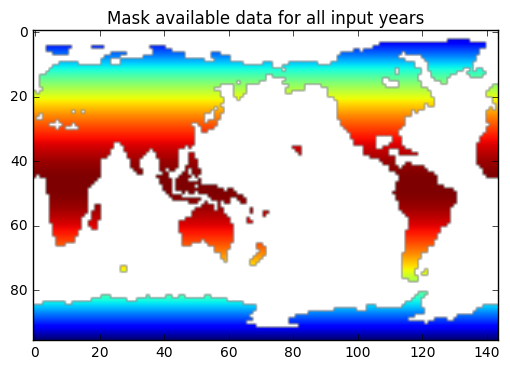

In [41]:
###########
# Settings
###########

# define periods
ref_period=[2005-19,2005]
target_periods=[ref_period,[2030-19,2030],[2080-19,2080]]
period_names=['ref','period1','period2']

# initiate object
varpdf=pdf.PDF_Processing(varin,'/Users/peterpfleiderer/Documents/Projects/0p5_observed/')

# Mask for data availability
# load land-mask if necessary
landmask=da.read_nc('support/144x96_landmask.nc')['landmask']

# get global mask
varpdf.mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask)

# Plot global mask
plt.figure()
plt.imshow(varpdf._masks['global'][::-1,:])
plt.title('Mask available data for all input years')

plt.show()

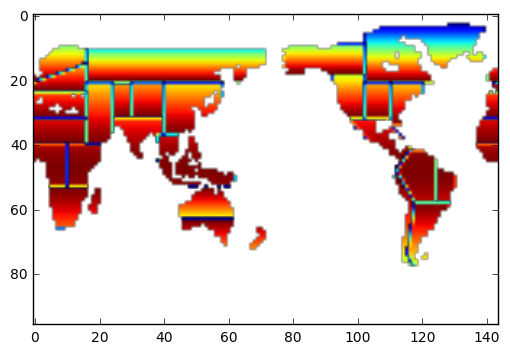

In [42]:
#########
# regional masking
#########

pkl_file = open('support/srex_dict.pkl', 'rb')
srex_polygons = pickle.load(pkl_file)
pkl_file.close()  

varpdf.derive_regional_masking(input_data,shift_lon=-180.0,regions_polygons=srex_polygons)

for region in varpdf._masks.keys():
    if region!='global':
        plt.imshow(varpdf._masks[region][::-1,:])
plt.show()

In [43]:
###########
# Derive time slices and distributions
###########
varpdf.derive_time_slices(input_data,ref_period,target_periods,period_names)
varpdf.derive_distributions()

# compute ks test
varpdf.ks_test('period1','period2')

ref [1986, 2005]
period1 [2011, 2030]
period2 [2061, 2080]


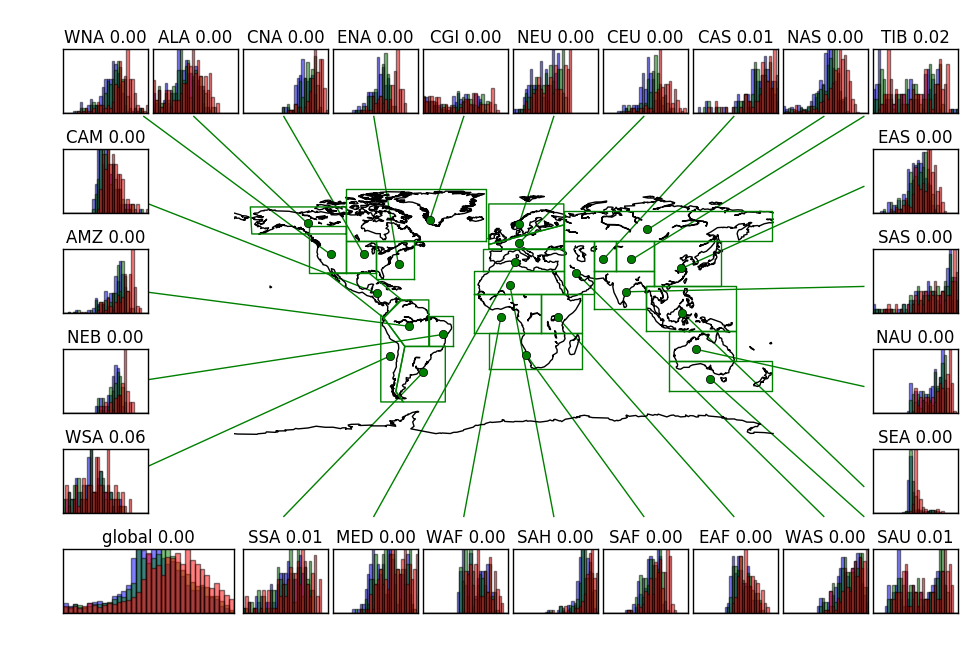

In [44]:
############
# show distributions
############

# plot function applied to all regions
def small_distribution(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    for key in varpdf._periods:
        histo=subax.hist(varpdf._distributions[region][key],bins=range(0,100,1),alpha=0.5)#,bins=20)
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    subax.set_xlim([15,50])
    subax.set_ylim([0,histo[0].max()])

# load plot settings
pkl_file = open('support/plot_settings.pkl', 'rb')
plot_settings = pickle.load(pkl_file)
pkl_file.close()  
    
varpdf.show_result(small_distribution,plot_settings,output_name=None)

In [45]:
##############
# kernel density estimation
##############

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['period1'].min()*0.9,varpdf._distributions[region]['period2'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_density_estimation(cutinterval,bw,region=region)
    

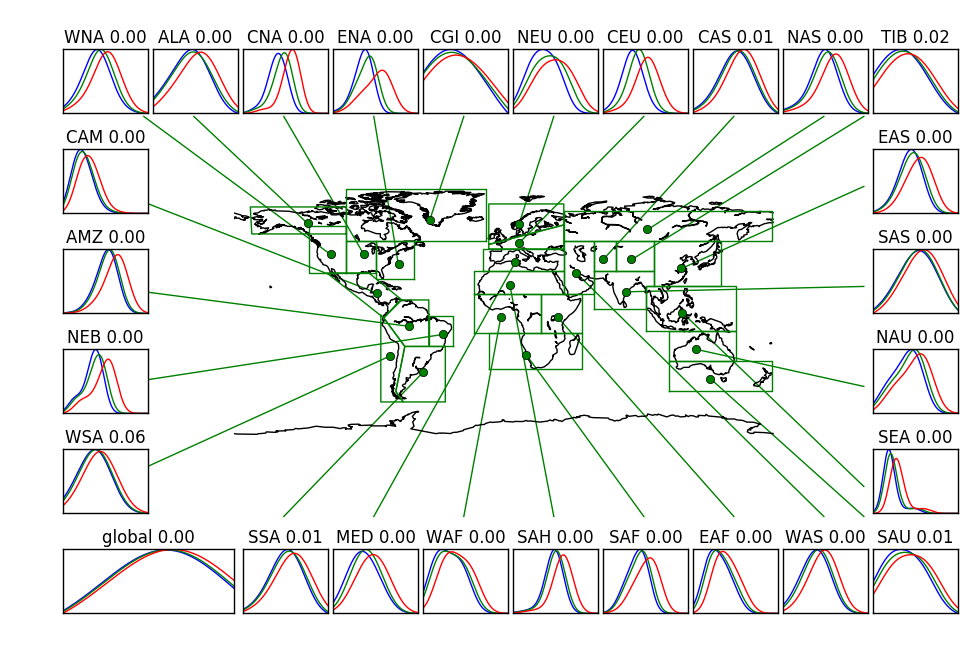

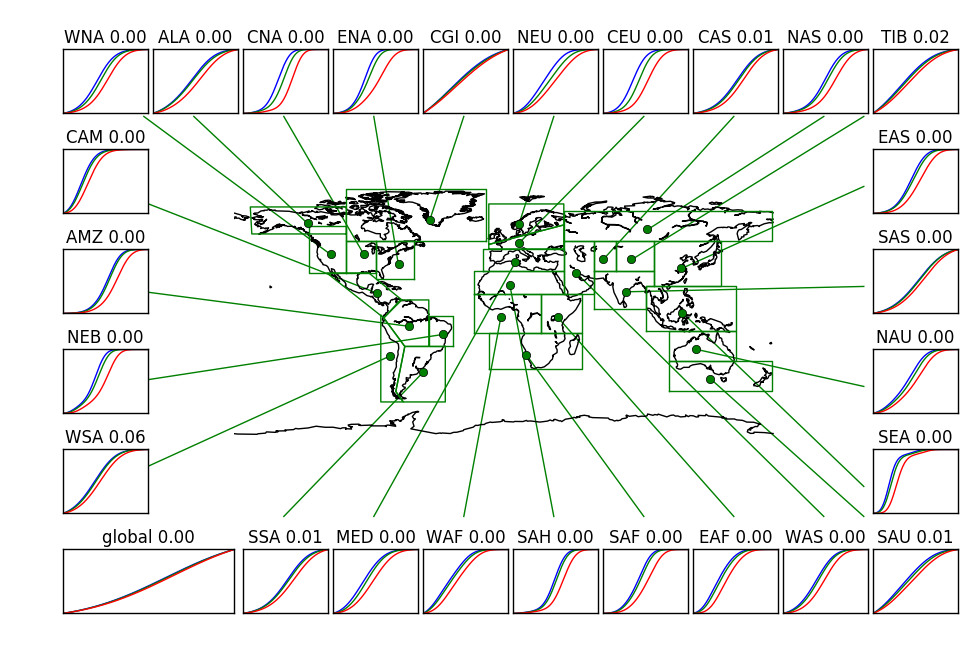

In [46]:
############
# Kernel Density Estimation Plots
############

# define plot funcions used later on
# For pdf
def small_kde(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])


    for key in varpdf._periods:
        pdf_distro=varpdf._distributions[region][key+'_pdf']
        subax.plot(pdf_distro[:,0],pdf_distro[:,1])
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    #subax.set_xlim([7,20])
    #subax.set_ylim([0,pdf_distro[:,1].max()])

# for cdf
def small_cumul(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    for key in varpdf._periods:
        cdf_distro=varpdf._distributions[region][key+'_cdf']
        subax.plot(cdf_distro[:,0],cdf_distro[:,1])
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    #subax.set_xlim([7,20])
    subax.set_ylim([0,1])
    
varpdf.show_result(small_kde,plot_settings,output_name=None)
varpdf.show_result(small_cumul,plot_settings,output_name=None)

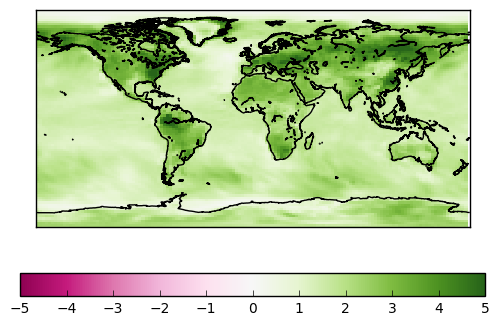

In [16]:
###########
# Show map with information on grid-cell level
###########

varpdf.show_maps(None,'period1','period2')

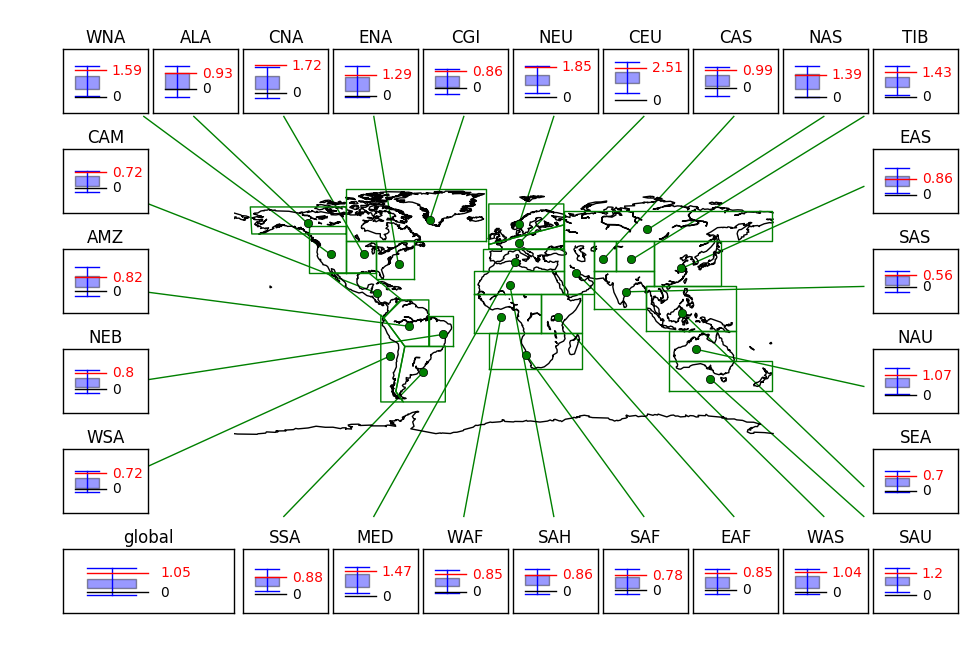

In [31]:
###########
# Bootstrapping
###########

# generate shuffled samples
varpdf.bootstrapping(input_data,100)

# compute regional mean for both periods and all samples
# compute differences between means and the quantiles for sample-differences
varpdf.simple_difference('ref','period1')


# plot function applied to all regions
time_comparison_str='period1-ref'

def small_boxplot(subax,region):
    global time_comparison_str
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    box=[varpdf._difference[region]['quantiles'][i][1] for i in [3,5]]
    subax.add_collection(PatchCollection([patches.Polygon([(4,box[0]),(6,box[0]),(6,box[1]),(4,box[1])])], alpha=0.4))
    polygon=Polygon([(4,box[0]),(6,box[0]),(6,box[1]),(4,box[1])]).exterior.xy
    whisker=[varpdf._difference[region]['quantiles'][i][1] for i in [1,7]]
    subax.plot([4,6],[whisker[0],whisker[0]],'b')
    subax.plot([4,6],[whisker[1],whisker[1]],'b')
    subax.plot([5,5],[whisker[0],whisker[1]],'b')

    subax.plot([4,6.5],[varpdf._difference[region][time_comparison_str],varpdf._difference[region][time_comparison_str]],color='r')
    subax.text(7,varpdf._difference[region][time_comparison_str],round(varpdf._difference[region][time_comparison_str],2),color='r',va ='center',ha='left').set_fontsize(10)

    subax.plot([4,6.5],[0,0],'k')
    subax.text(7,0,0,va ='center',ha='left').set_fontsize(10)

    subax.title.set_text(region)
    subax.set_xlim([3,10])
    subax.set_ylim([min(varpdf._difference[region][time_comparison_str],0,whisker[0])-1,max(varpdf._difference[region][time_comparison_str],0,whisker[1])+1])

varpdf.show_result(small_boxplot,plot_settings,output_name=None)